# Underlying Price Distribution From Options Prices

## Environment setup and imports

In [74]:
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

## Utility Functions

In [2]:
def discrete_expectation(f, dist):
    outputs = f(dist["x"].values) * dist["pdf"].values
    average_outputs = (outputs[:-1] + outputs[1:]) / 2
    dx = dist["x"][1:].values - dist["x"][:-1].values
    return (average_outputs * dx).sum()

In [3]:
def create_normal_distribution(mu=0, sigma=1, max_x=100, N=1000):
    pdf = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))
    x_range = np.linspace(-max_x, max_x, N)
    dist = pd.DataFrame({
        "x": x_range,
        "pdf": pdf(x_range)
    })
    return dist

In [4]:
def plot_dist(dist):
    plt.xlabel("x")
    plt.ylabel("pdf")
    plt.plot(dist["x"], dist["pdf"])

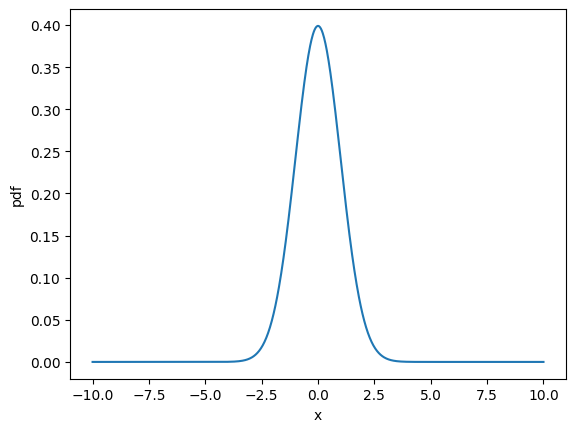

In [5]:
dist = create_normal_distribution(0, 1, max_x=10)
plot_dist(dist)

In [6]:
norm = discrete_expectation(np.vectorize(lambda x: 1), dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 0.0
Variance: 1.0


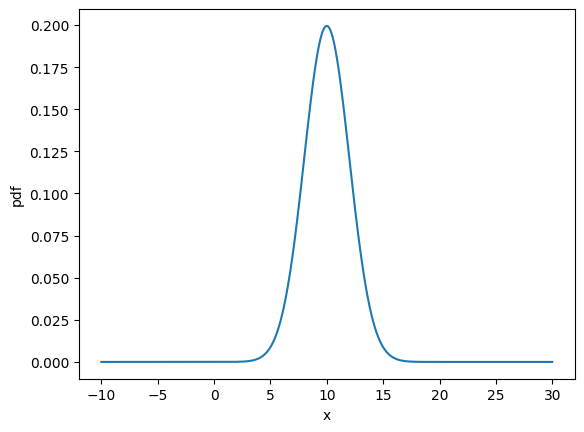

In [7]:
n_dist = dist.copy()
n_mu = 10
n_sigma = 2
n_dist["x"] = n_dist["x"] * n_sigma + n_mu
n_dist["pdf"] = n_dist["pdf"] / n_sigma

plt.xlabel("x")
plt.ylabel("pdf")
plt.plot(n_dist["x"], n_dist["pdf"])
plt.show()

In [8]:
norm = discrete_expectation(np.vectorize(lambda x: 1), n_dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, n_dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, n_dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 10.000000000000002
Variance: 4.000000000000001


In [9]:
def secant_method(f, a, b, epsilon=1e-2):
    if f(a) * f(b) >= 0:
        return None
    a_n = a
    b_n = b
    f_a_n = f(a_n)
    f_b_n = f(b_n)
    while True:
        m_n = a_n - f_a_n*(b_n - a_n)/(f_b_n - f_a_n)
        f_m_n = f(m_n)
        if abs(f_m_n) < epsilon:
            return m_n
        elif f_a_n*f_m_n < 0:
            b_n = m_n
            f_b_n = f(b_n)
        elif f_b_n*f_m_n < 0:
            a_n = m_n
            f_a_n = f(a_n)
        else:
            return None

In [10]:
secant_method(lambda x: x * x - 4, -1, 2.5)

1.9981718464351006

## Options Pricing Model

Let's say you have an option with some payout function: $p(x)$. For example, a call option with strike $K$ has a payout $p(x) = \max(0, x - K)$.

Let's say this is a European option that can only be exercised on expiration for simplicity. Let the expiration be $T$ years away. Let the underlying price at any time $U_t$ be distributed according to
$$ U_t \sim f(x) = \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big) $$

where $D_{\vec{\theta}}$ is some distribution fully parameterized by $\theta$ and has the following properties (let $S \sim D_{\vec{\theta}}(x)$):

* $E[S] = 0$
* $Var(S) = Std(S) = 1$

As a result,
* $E[U_t] = U_0$
* $Std(U_t) = \sigma \sqrt{t}$ and $Var(U_t) = \sigma^2 t$

So, $\sigma$ represents the annual standard deviation of the underlying. I will refer to this as the volatility for this work even though it is not in log space. Now the price of the this option $\Phi$ with expiration $T$ should be as follows:

$$ (1+r)^T\Phi_T = E[p(U_T)] \rightarrow \Phi_T = \frac{E[p(U_T)]}{(1+r)^T} $$

where $r$ is the risk free interest rate.

$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(x) \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$
$$ \Phi_T = \frac{1}{(1+r)^T \sigma\sqrt{T}}\int_{-\infty}^{\infty} p(x) D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$

Thus, we have a formula for an option price, given a payout function $p(x)$, the normalized distribution of the underlying price $D_{\vec{\theta}}$, the current underlying price $U_0$, the underlying price annual standard deviation $\sigma$, the time till expiration $T$ in years, and the risk free interest rate $r$.

Note that we can use a change of variable $z = \frac{x-U_0}{\sigma\sqrt{T}}$ and $dx = \sigma\sqrt{T} dz$ to simply this equation to
$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(\sigma\sqrt{T}z + U_0) D_{\vec{\theta}}(z)dz $$


In [11]:
def price_option(payout, normalized_distribution, current_underlying_price, underlying_sigma, expiration_time, interest_rate):
    if expiration_time > 0:
        phi_T = discrete_expectation(
            lambda z: payout(underlying_sigma * np.sqrt(expiration_time) * z + current_underlying_price),
            normalized_distribution
        ) / (1 + interest_rate) ** expiration_time
    else:
        phi_T = float(payout(current_underlying_price))
    return phi_T

Now, using this function, let us plot a call option price over the possible strikes and expiration times. Remember, the call option payout $p(x)$ for a given strike $K$ is $\max(0, x-K)$. To use the functions above, this must be written in a vectorized fashion using `np.where`. Let us also assume that the stock price follows a normal distribution for now. 

In [12]:
call_option_payout = lambda k: (lambda x: np.where(x < k, 0, x - k))

In [135]:
dist = create_normal_distribution(max_x=10, N=200)
u_0 = 200
sigma = 20
r = 0.05

In [136]:
price_option(call_option_payout(201), dist, u_0, sigma, 1/12, r)

1.8303721433547993

In [137]:
ks = np.linspace(180, 220, 40)
exp_t_months = [0, 0.25, 0.5, 1, 2, 3, 6, 12, 24]

option_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        option_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, sigma, exp_t_month/12, r)

Calculating 0 month option prices . . .


100%|██████████| 40/40 [00:00<?, ?it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7953.55it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10005.50it/s]


Calculating 1 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10001.32it/s]


Calculating 2 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 9910.93it/s]


Calculating 3 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7998.67it/s]


Calculating 6 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10027.62it/s]


Calculating 12 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 13205.21it/s]


Calculating 24 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10001.92it/s]


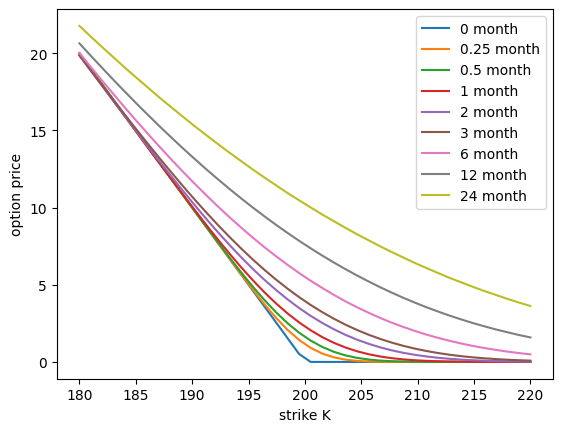

In [138]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, option_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

This looks like a reasonable payout graph for an option with the given parameters.

Another plot that can be made is given a strike and expiration time, how does the option price change as the volatility changes.

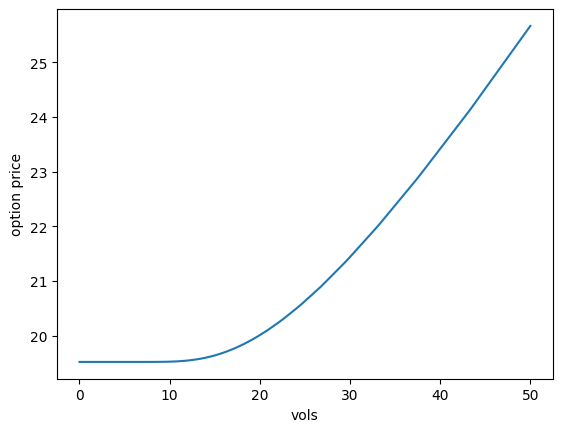

In [139]:
k = 180
exp_T = 1/2

vols = np.linspace(0, 50, 100)
prices = [price_option(call_option_payout(k), dist, u_0, v, exp_T, r) for v in vols]

plt.xlabel("vols")
plt.ylabel("option price")
plt.plot(vols, prices)
plt.show()

As we expected, we get a monotone increasing function. As the volatility of an underlying increases, so does the option price.

## Calculating Strike Vols

To calculate the implied volatility given a strike (and the corresponding payout function) and the current option price from marketdata (use mid or swmid), the inverse of the function above essentially must be calculated. Unfortunately this cannot be easily solved analytically. Instead, it can be done computationally using the secant method since it doesn't require knowing the derivative of a function.

Also, note that we focus on call options here since puts are slightly overpriced due to the addition demand that hedgers bring.

In [140]:
def calculate_implied_volatility(option_price, payout, normalized_distribution, current_underlying_price, expiration_time, interest_rate, max_vol_percent=0.5, epsilon=1e-2):
    def f(vol):
        return price_option(payout, normalized_distribution, current_underlying_price, vol, expiration_time, interest_rate) - option_price
    res = secant_method(f, 0, max_vol_percent * current_underlying_price, epsilon)
    return 0 if res is None else res

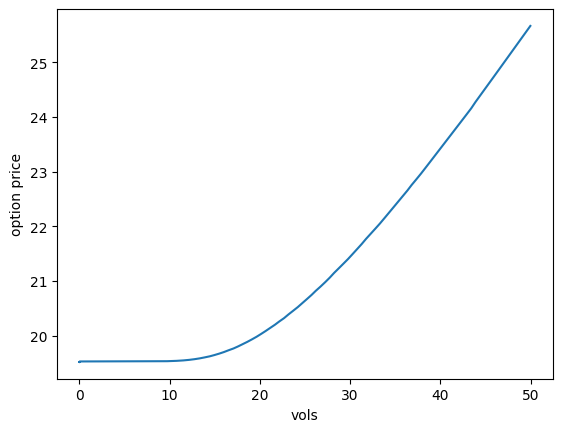

In [141]:
implied_vols = [calculate_implied_volatility(p, call_option_payout(k), dist, u_0, exp_T, r) for p in prices]

plt.xlabel("vols")
plt.ylabel("option price")
plt.plot(implied_vols, prices)
plt.show()

As we see we are able to recover the original vols given the option prices and construct the same graph as before. 

Now, lets see if we can use the option_prices matrix to get the volatility we used in the calculations further above.

In [144]:
implied_vols = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month vols . . .")
    for j in tqdm(range(len(ks))):
        implied_vols[i, j] = calculate_implied_volatility(option_prices[i, j], call_option_payout(ks[j]), dist, u_0, exp_t_month/12, r, epsilon=0.01)

flattened_implied_vols = implied_vols.flatten()

print(flattened_implied_vols.mean())
print(flattened_implied_vols.std())

Calculating 0 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 40069.78it/s]


Calculating 0.25 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 689.42it/s]


Calculating 0.5 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 481.81it/s]


Calculating 1 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 336.14it/s]


Calculating 2 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 198.97it/s]


Calculating 3 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 454.37it/s]


Calculating 6 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 702.08it/s]


Calculating 12 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 952.48it/s]


Calculating 24 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 930.22it/s]

14.401032951512606
8.815255353030892


In [145]:
for i in range(len(exp_t_months)):
    print(implied_vols[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.59403897e-10 1.60483161e-09 1.52779468e-08 1.24395598e-07
 9.15732657e-07 5.99024657e-06 3.47394869e-05 1.81243141e-04
 8.30125116e-04 3.48148330e-03 1.27136016e-02 4.26651651e-02
 1.25691433e-01 1.42191166e+01 1.86651469e+01 1.93884043e+01
 1.97411251e+01 1.97428999e+01 1.99803543e+01 1.99470332e+01
 1.99470332e+01 1.99803543e+01 1.97428999e+01 1.97411251e+01
 1.93884043e+01 1.86651469e+01 1.42191166e+01 1.25691433e-01
 4.26651651e-02 1.27136016e-02 3.48148330e-03 8.30125117e-04
 1.81243141e-04 3.47394870e-05 5.99024652e-06 9.15732733e-07
 1.24396380e-07 1.52776528e-08 1.60521197e-09 1.59063014e-10]
[2.11308795e-05 7.04205012e-05 2.19870372e-04 6.53163337e-04
 1.82318829e-03 4.83647978e-03 1.20876908e-02 2.86961793e-02
 6.43463337e-02 1.37074299e-01 1.63055494e+01 1.87421118e+01
 1.93708152e+01 1.95701545e+01 1.98140883e+01 1.98576519e+01
 1.99309682e+01 1.9934

We notice that there is a decent bit of error in the calculation. Looking at implied vols, it looks like the expiration dates with small time till expiration do not seem to really contain the information of the volatility of the underlying. This is confirmed in the next few cells, where we are still able to approximately reconstruct the options prices using these implied vols (even when they are set to pretty much 0).

In [146]:
implied_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        implied_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, implied_vols[i, j], exp_t_month/12, r)

Calculating 0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 39917.24it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5725.43it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10016.25it/s]


Calculating 1 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7991.43it/s]


Calculating 2 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10010.27it/s]


Calculating 3 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 8022.39it/s]


Calculating 6 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10106.15it/s]


Calculating 12 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 8025.46it/s]


Calculating 24 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10003.71it/s]


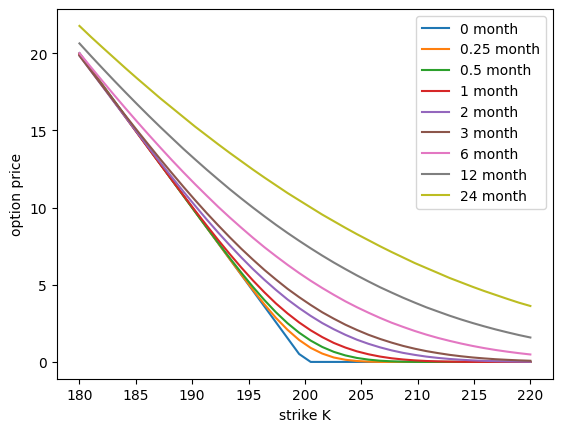

In [147]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, implied_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

We can also print the strike vol curve (vols as a function of strike prices) and confirm that where the information of the volatility is stored. 

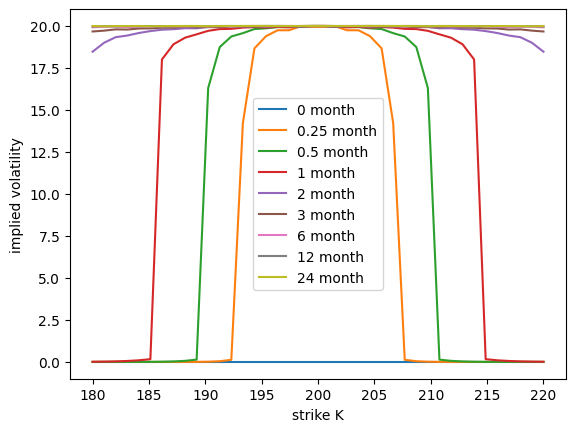

In [148]:
plt.xlabel("strike K")
plt.ylabel("implied volatility")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, implied_vols[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

Thus, a good estimator for the true volatility would just be to ignore any outliers (outside of 1 std from the mean), and then look at the results. This cleaning process can be run as many times as we want to narrow down the data. The more times we clean the smaller the variance will be.

In [152]:
cleaning_rounds = 2
cleaned_implied_vols = flattened_implied_vols
for _ in range(cleaning_rounds):
    cleaned_implied_vols = cleaned_implied_vols[np.abs(cleaned_implied_vols - cleaned_implied_vols.mean()) < cleaned_implied_vols.std()]
print(cleaned_implied_vols.mean())
print(cleaned_implied_vols.std())

19.911112805390875
0.14819626521754944


This is a much better estimate for the volatility, but in practice we should just choose data that would contain the volatility information in the option price. To do so, we just pick strikes that are not too far from the current price and expiration times that are not too close to the current time.

## Recovering the normalized distribution

Above is a way to calculate $\sigma_{K, T}$, which is the volatility implied by the call option prices for a given strike $K$ and time till expiration $T$. Note that this calculation is conditioned on the normalized distribution $D_{\vec{\theta}}$. This means when we construct the strike volatility curves/surface, it is parametrized by $\theta$.

Since $\sigma$ is a property of the underlying and not of the option, it theoretically should be invariant to $K$ and $T$. Thus, in theory,

$$ \sigma = E[\sigma_{K,T}] = \frac{1}{N_K * N_T} \sum_{K} \sum_{T} \sigma_{K, T} = \sigma_{K, T} \quad \forall \quad K, T $$
$$ Var(\sigma_{K, T}) = \frac{1}{N_K * N_T} \sum_{K} \sum_{T} (\sigma_{K, T} - \sigma)^2 = 0 $$

where $N_K$ and $N_T$ are the number of strikes and expirations respectively.

However, this not actually the case when the calculations are performed. This is mainly because of two reasons:
* sometimes the options price doesn't really contain the volatility information of the stock (consider when $T=0$)
* the assumed distribution of the stock $D_{\vec{\theta}}$ doesn't match with the underlying distribution predicted by the market

In the above work, we assume that the underlying prices are normally distributed, which is a good assumption considering we created them to be normally distributed. What if instead attempted to try to fit the correct distribution parameters $\hat{theta}$ by minimizing the standard deviation of our cleaned implied volatility's.

This is effectively a constrained optimization problem:

$$\hat{\theta} = \argmin_{\vec{\theta}} Var(\sigma_{K, T}) $$

where 

$$ \sigma_{K,T} \text{ is calculated from options prices in market data} $$
$$ \sigma = E[\sigma_{K,T}] = \frac{1}{N_K * N_T} \sum_{K} \sum_{T} \sigma_{K, T} $$
$$ Var(\sigma_{K, T}) = \frac{1}{N_K * N_T} \sum_{K} \sum_{T} (\sigma_{K, T} - \sigma)^2 $$

with the constraints
$$ \big[\int_{-\infty}^\infty D_{\vec{\theta}}(x) dx \big] - 1 = 0 $$
$$ \big[\int_{-\infty}^\infty xD_{\vec{\theta}}(x) dx \big] = 0 $$
$$ \big[\int_{-\infty}^\infty x^2 D_{\vec{\theta}}(x) dx \big] - 1 = 0 $$

and 
* $D_{\vec{\theta}}$ is a function on $\mathbb{R}$ parameterized by $\vec{\theta}$
* $N_K$, $N_T$, and option prices are all given from marketdata
* $r$ is the current risk free interest rate


To parameterize $D_{\vec{\theta}}$, we can define $D_{\vec{\theta}}$ to be the inverse fourier transform of $\vec{theta}$. This is because the distribution in frequency space (the characteristic function) should be easier to learn and contain more semantic information than the literal discretized pdf.

An extra post processing step is also applied to enforce the variance of the distribution to be 1:

$$ T \sim t(x) = ifft(\theta) $$

$$ D_{\vec{\theta}}(x) = Std(T) t(x \times Std(T)) $$

In [26]:
def dist_to_theta(dist):
    n = len(dist["x"])
    x_max = -dist["x"][0]

    theta = np.fft.fftshift(np.fft.fft(dist["pdf"])) * 2 * x_max / n
    return theta

In [27]:
def theta_to_dist(theta, x_vals):
    n = len(x_vals)
    x_max = -x_vals[0]

    pdf = np.abs(np.fft.ifft(np.fft.ifftshift(theta) * n / (2 * x_max)))

    t_dist = pd.DataFrame({"x": x_vals, "pdf": pdf})

    std_t = np.sqrt(discrete_expectation(lambda x: x * x, t_dist))

    dist = pd.DataFrame({"x": x_vals / std_t, "pdf": pdf * std_t})

    return dist

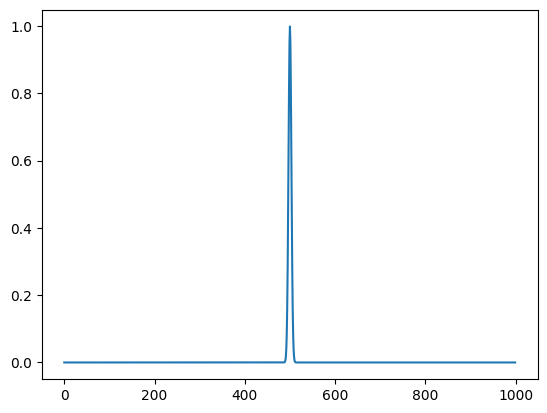

In [28]:
dist = create_normal_distribution(mu=0, sigma=1, max_x=10)
theta = dist_to_theta(dist)

plt.plot(np.abs(theta))
plt.show()

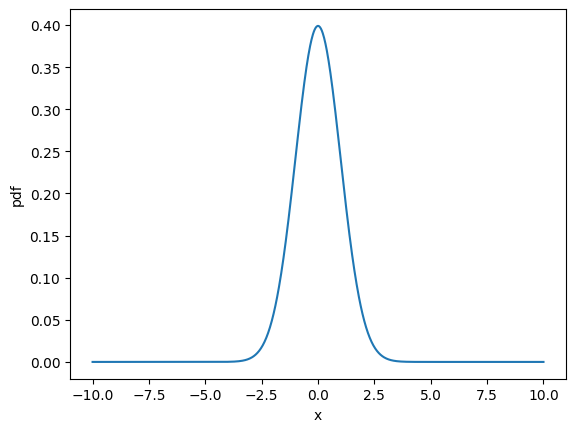

In [29]:
plot_dist(dist)

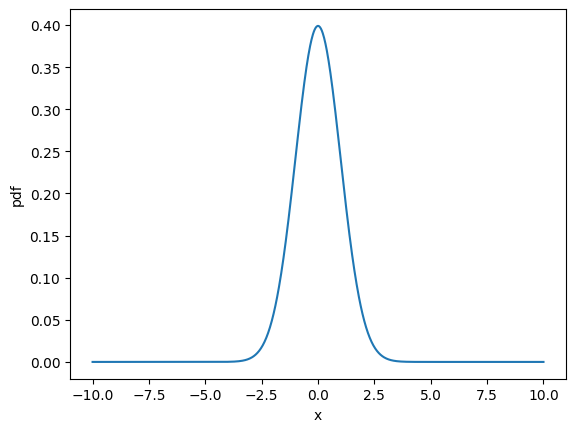

In [30]:
pred_dist = theta_to_dist(theta, dist["x"])
plot_dist(pred_dist)

Note that this makes forcing the first constraint listed above (normalization) really simple: the amount of frequency 0 must be set to exactly 1 (since we have scaled the output of the fourier transform correctly) as by definition of the fourier transform

$$ F(0) = \int_{-\infty}^{\infty} D_{\vec{\theta}}(x) dx $$

This override can be done as a preprocessing step.

In [31]:
print(theta[len(theta) // 2])

(0.9990000000000002+0j)


Forcing the second constraint can also be done relatively trivially. It has be proven that the expectation of a random variable is equal to $i\phi'(0)$ where $\phi$ is the characteristic function, or the fourier transform of the pdf. Thus, we can approximate this derivative using a central difference. It should be noted that the input frequency space of the fourier transform has not been properly scaled, but this doesn't matter as this derivative is being set to 0, so any constants will not make a difference. So, this extra term can be tossed into the minimization function.

In [32]:
np.abs(theta[len(theta) // 2 + 1] - theta[len(theta) // 2 - 1])

0.005975247657016725

Just to ensure all three constraints are held, we can run the following cell:

In [33]:
print(discrete_expectation(lambda x: 1, pred_dist))
print(discrete_expectation(lambda x: x, pred_dist))
print(discrete_expectation(lambda x: x * x, pred_dist))


1.0000000000000002
2.7755575615628914e-16
1.0


Now, it is possible to use the scipy optimization library to minimize the variance of our strike vols and force the constraints above.

In [179]:
def optimize_distribution_to_flatten_strike_vol_surface(init_dist, option_prices, exp_t_months, ks, u_0, r, payout_generator=call_option_payout, epsilon=0.01, cleaning_rounds=1, alpha=1, tol=1e-6, method="Powell", verbose=False):
    
    x_vals = init_dist["x"]
    n = len(init_dist)


    def theta_to_f_theta(theta):
        temp = np.array([np.real(theta[1:]), np.imag(theta[1:])])
        f_theta = temp.reshape((2 * n - 2, ))
        return f_theta

    def f_theta_to_theta(f_theta):
        temp = f_theta.reshape((2, n - 1))
        theta = np.array([0] + list(temp[0] + 1j * temp[1]))
        return theta

    def f(f_theta):
        theta = f_theta_to_theta(f_theta)
        dist = theta_to_dist(theta, x_vals)

        implied_vols = np.zeros((len(exp_t_months), len(ks)))

        for i, exp_t_month in enumerate(exp_t_months):
            for j in range(len(ks)):
                implied_vols[i, j] = calculate_implied_volatility(option_prices[i, j], payout_generator(ks[j]), dist, u_0, exp_t_month/12, r, epsilon=epsilon)

        cleaned_implied_vols = implied_vols.flatten()
        for _ in range(cleaning_rounds):
            cleaned_implied_vols = cleaned_implied_vols[np.abs(cleaned_implied_vols - cleaned_implied_vols.mean()) < cleaned_implied_vols.std()]

        loss = cleaned_implied_vols.std() + alpha * np.abs(theta[len(theta) // 2 + 1] - theta[len(theta) // 2 - 1])

        return loss
    
    init_theta = dist_to_theta(init_dist)
    init_f_theta = theta_to_f_theta(init_theta)

    opt_res = scipy.optimize.minimize(f, init_f_theta, method=method, tol=tol, options={ "disp": verbose })

    f_theta_hat = opt_res.x
    theta_hat = f_theta_to_theta(f_theta_hat)
    dist_hat = theta_to_dist(theta_hat, x_vals)

    return theta_hat, dist_hat

Now, we can attempt to recover the gaussian distribution below using the generated option prices. We will initially guess a uniform distribution (obviously wrong).

In [180]:
dist = create_normal_distribution(max_x=10, N=200)
u_0 = 200
sigma = 20
r = 0.05

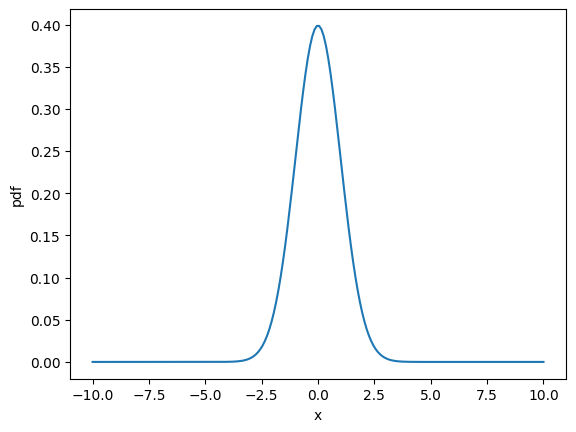

In [181]:
plot_dist(dist)

In [182]:
ks = np.linspace(180, 220, 40)
exp_t_months = np.array([0, 0.25, 0.5, 1, 2, 3, 6, 12, 24])

In [183]:
option_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        option_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, sigma, exp_t_month/12, r)

Calculating 0.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 13288.88it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7999.44it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6664.77it/s]


Calculating 1.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 8022.39it/s]


Calculating 2.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5753.90it/s]


Calculating 3.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6667.41it/s]


Calculating 6.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6656.83it/s]


Calculating 12.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7923.87it/s]


Calculating 24.0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 9994.17it/s]


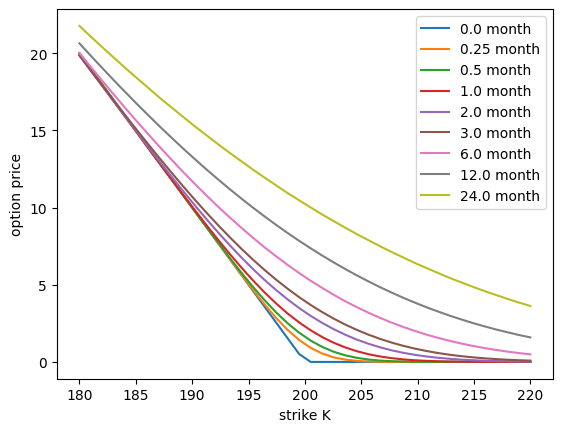

In [184]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, option_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

We need to create a uniform distribution with 0 mean and unit variance. Let's define this function as 

* $f(x) = \frac{1}{2a}$ when $|x| < a$
* $f(x) = 0$ otherwise

Note that this is a valid distribution as the area under the box is exactly 1. The mean is 0 since the box is centered at 0. Now, we just need to choose an $a$ to set the variance $V$ to 1.

$$V = \frac{1}{2a} \int_{-a}^a x^2 dx = \frac{1}{2a} \frac{x^3}{3}\big|_{-a}^a = \frac{1}{2a}[\frac{a^3}{3} - \frac{-a^3}{3}] = \frac{a^2}{3} = 1$$

Solving for $a$,

$$ a = \sqrt{3} $$

It may feel weird to be hard coding and solving for this initial distribution, but it is important to remember that this normalized distribution just characterizes the shape of the distribution.

In [185]:
x_vals = dist["x"]
a = np.sqrt(3)
pdf = np.ones_like(x_vals) / (2 * a)
pdf[x_vals < -a] = 0
pdf[x_vals > a] = 0

init_dist = pd.DataFrame({ "x": x_vals, "pdf": pdf })

0.9864275956003656
8.881784197001252e-16
0.9590026118182386


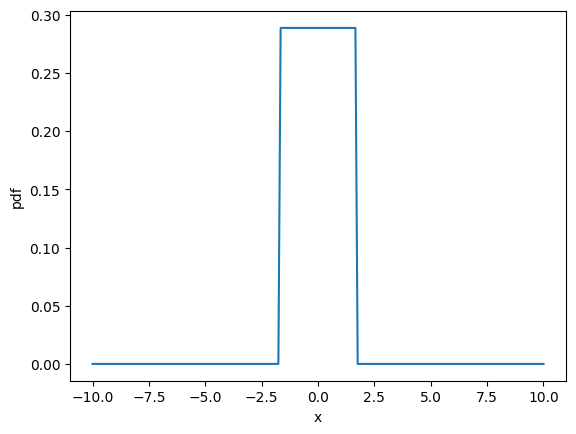

In [186]:
print(discrete_expectation(lambda x: 1, init_dist))
print(discrete_expectation(lambda x: x, init_dist))
print(discrete_expectation(lambda x: x * x, init_dist))
plot_dist(init_dist)

In [193]:
start_time = time.time()

theta_hat, dist_hat = optimize_distribution_to_flatten_strike_vol_surface(
    init_dist=init_dist,
    option_prices=option_prices,
    exp_t_months=exp_t_months,
    ks=ks,
    u_0=u_0,
    r=r,
    payout_generator=call_option_payout, 
    epsilon=0.01, 
    cleaning_rounds=2, 
    alpha=1, 
    tol=0.05,
    method="L-BFGS-B",
    verbose=True,
)

elapsed_time = time.time() - start_time

print(f"Took {elapsed_time} seconds to run")

Took 1032.4610359668732 seconds to run


1.018667059221972
-0.07212756195978604
1.0000000000000042


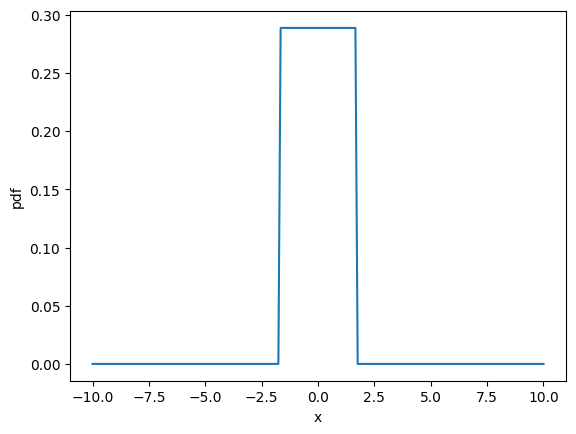

In [197]:
print(discrete_expectation(lambda x: 1, dist_hat))
print(discrete_expectation(lambda x: x, dist_hat))
print(discrete_expectation(lambda x: x * x, dist_hat))
plot_dist(init_dist)

In [198]:
implied_vols = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    for j in range(len(ks)):
        implied_vols[i, j] = calculate_implied_volatility(option_prices[i, j], call_option_payout(ks[j]), dist, u_0, exp_t_month/12, r, epsilon=0.01)

cleaned_implied_vols = implied_vols.flatten()
for _ in range(cleaning_rounds):
    cleaned_implied_vols = cleaned_implied_vols[np.abs(cleaned_implied_vols - cleaned_implied_vols.mean()) < cleaned_implied_vols.std()]

cleaned_implied_vols.std()

0.14819626521754944

In [199]:
np.abs(theta_hat[len(theta_hat) // 2 + 1] - theta_hat[len(theta_hat) // 2 - 1])

0.02794243799810487